In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import re
%matplotlib inline

## Alexandre Dumas
### The Black Tulip

In [2]:
BODY_START = 39
BODY_END = 10133
CHAP_PAT = r'^\s*(?:Chapter).*$'
PARA_PAT = r'\n\n+'
SENT_PAT = r'([.;?!"“”]+)'
TOKEN_PAT = r'([\W_]+)'
src_file = 'data/The_Black_Tulip.txt'

In [3]:
lines = open(src_file, 'r', encoding='utf-8').readlines()

In [4]:
lines = lines[BODY_START - 1 : BODY_END + 1]

In [5]:
lines[:10]

['Chapter 1. A Grateful People\n',
 '\n',
 '\n',
 'On the 20th of August, 1672, the city of the Hague, always so lively,\n',
 'so neat, and so trim that one might believe every day to be Sunday, with\n',
 'its shady park, with its tall trees, spreading over its Gothic houses,\n',
 'with its canals like large mirrors, in which its steeples and its almost\n',
 'Eastern cupolas are reflected,--the city of the Hague, the capital of\n',
 'the Seven United Provinces, was swelling in all its arteries with a\n',
 'black and red stream of hurried, panting, and restless citizens, who,\n']

In [6]:
df = pd.DataFrame({'line_str':lines})
df.index.name = 'line_id'

In [7]:
df.head()

,line_str
line_id,
0,Chapter 1. A Grateful People\n
1,\n
2,\n
3,"On the 20th of August, 1672, the city of the H..."
4,"so neat, and so trim that one might believe ev..."


In [8]:
import nltk
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('tagsets')
# nltk.download('wordnet')

In [9]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

In [10]:
def text_to_tokens(
                   src_file,
                   body_start=0, 
                   body_end=-1, 
                   chap_pat=r'^\s*Chapter.*$', 
                   para_pat=r'\n\n+', 
                   sent_pat=r'([.;?!"“”]+)', 
                   token_pat=r'([\W_]+)'):

    # Text to lines
    lines = open(src_file, 'r', encoding='utf-8').readlines()
    lines = lines[body_start - 1 : body_end + 1]
    df = pd.DataFrame({'line_str':lines})
    df.index.name = 'line_id'
    del(lines)
    
    # FIX CHARACTERS TO IMPROVE TOKENIZATION
    df.line_str = df.line_str.str.replace('—', ' — ')
    df.line_str = df.line_str.str.replace('-', ' - ')

    # Lines to Chapters
    mask = df.line_str.str.match(chap_pat)
    df.loc[mask, 'chap_id'] = df.apply(lambda x: x.name, 1)
    df.chap_id = df.chap_id.ffill().astype('int')
    chap_ids = df.chap_id.unique().tolist()
    df['chap_num'] = df.chap_id.apply(lambda x: chap_ids.index(x))
    chaps = df.groupby('chap_num')\
        .apply(lambda x: ''.join(x.line_str))\
        .to_frame()\
        .rename(columns={0:'chap_str'})
    del(df)

    # Chapters to Paragraphs
    paras = chaps.chap_str.str.split(para_pat, expand=True)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'para_str'})
    paras.index.names = PARAS
    paras.para_str = paras.para_str.str.strip()
    paras.para_str = paras.para_str.str.replace(r'\n', ' ')
    paras.para_str = paras.para_str.str.replace(r'\s+', ' ')
    paras = paras[~paras.para_str.str.match(r'^\s*$')]
    del(chaps)

    # Paragraphs to Sentences
#     sents = paras.para_str.str.split(sent_pat, expand=True)\
    sents = paras.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    sents.index.names = SENTS
    del(paras)

    # Sentences to Tokens
#     tokens = sents.sent_str.str.split(token_pat, expand=True)\
    tokens = sents.sent_str\
        .apply(lambda x: pd.Series(nltk.pos_tag(nltk.word_tokenize(x))))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    tokens.index.names = OHCO
    del(sents)
    
    tokens['pos'] = tokens.pos_tuple.apply(lambda x: x[1])
    tokens['token_str'] = tokens.pos_tuple.apply(lambda x: x[0])
    tokens = tokens.drop('pos_tuple', 1)

    # Tag punctuation and numbers
    tokens['punc'] = tokens.token_str.str.match(r'^[\W_]*$').astype('int')
    tokens['num'] = tokens.token_str.str.match(r'^.*\d.*$').astype('int')
    
    # Extract vocab with minimal normalization
    WORDS = (tokens.punc == 0) & (tokens.num == 0)
    tokens.loc[WORDS, 'term_str'] = tokens.token_str.str.lower()\
        .str.replace(r'["_*.]', '')
    
    vocab = tokens[tokens.punc == 0].term_str.value_counts().to_frame()\
        .reset_index()\
        .rename(columns={'index':'term_str', 'term_str':'n'})
    vocab = vocab.sort_values('term_str').reset_index(drop=True)
    vocab.index.name = 'term_id'
    
    # Get priors for V
    vocab['p'] = vocab.n / vocab.n.sum()
    
    # Add stems
    stemmer = nltk.stem.porter.PorterStemmer()
    vocab['port_stem'] = vocab.term_str.apply(lambda x: stemmer.stem(x))
    
    # Define stopwords
    sw = pd.DataFrame({'x':1}, index=nltk.corpus.stopwords.words('english'))
    vocab['stop'] = vocab.term_str.map(sw.x).fillna(0).astype('int')
    del(sw)
            
    # Add term_ids to tokens 
    tokens['term_id'] = tokens['term_str'].map(vocab.reset_index()\
        .set_index('term_str').term_id).fillna(-1).astype('int')

    return tokens, vocab

def get_docs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

In [11]:
cfg = dict(
    src_file = src_file,
    body_start = 39,
    body_end = 10133,
    chap_pat = r'^\s*(?:Chapter).*$'
)
BT_K, BT_V = text_to_tokens(**cfg)

In [12]:
BT_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NN   Chapter     0    0   chapter   
                           1          CD         1     0    1       NaN   
                           2           .         .     1    0       NaN   
                  1        0          DT         A     0    0         a   
                           1          JJ  Grateful     0    0  grateful   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0              893  
                           1               -1  
                           2               -1  
                  1        0                0  
                           1             2552

In [13]:
BT_K = BT_K.loc[BT_K.term_id >= 0]

In [14]:
BT_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NN   Chapter     0    0   chapter   
                  1        0          DT         A     0    0         a   
                           1          JJ  Grateful     0    0  grateful   
                           2          NN    People     0    0    people   
         1        0        0          IN        On     0    0        on   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0              893  
                  1        0                0  
                           1             2552  
                           2             4058  
         1        0        0             3874

In [15]:
BT_V.head()

,term_str,n,p,port_stem,stop
term_id,,,,,
0,a,1296,0.017496,a,1
1,abandoned,3,0.000041,abandon,0
2,abashed,2,0.000027,abash,0
3,abhor,1,0.000014,abhor,0
4,abide,2,0.000027,abid,0


In [16]:
WORDS = (BT_K.punc == 0) & (BT_K.num == 0) & BT_K.term_id.isin(BT_V[BT_V.stop==0].index)

In [17]:
BOW = BT_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [18]:
DTM = BOW.unstack().fillna(0)

In [19]:
DTM.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,6304,6305,6306,6307,6309,6310,6315,6316,6317,6318
chap_num,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
alpha = .000001
alpha_sum = alpha * BT_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [21]:
N_docs = DTM.shape[0]
BT_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / BT_V[BT_V.stop==0]['df'])

In [22]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,6304,6305,6306,6307,6309,6310,6315,6316,6317,6318
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.196456e-09,2.567859e-09,3.202777e-09,2.567859e-09,0.000874,3.202777e-09,3.202777e-09,2.567859e-09,3.202780e-03,3.202777e-09,...,2.196458e-03,1.932943e-03,3.202777e-09,3.202777e-09,2.293534e-03,3.202777e-09,2.196456e-09,3.202777e-09,1.932941e-09,3.202777e-09
1,2.789850e-09,3.261592e-09,4.068039e-09,3.261592e-09,0.001110,4.068039e-09,4.068039e-09,3.261592e-09,4.068039e-09,4.068039e-09,...,2.789850e-09,2.455144e-09,4.068039e-09,4.068039e-09,5.826309e-10,4.068039e-09,2.789850e-09,4.068039e-09,2.455144e-09,4.068039e-09
2,2.451748e-09,2.866319e-09,3.575033e-09,2.866319e-09,0.000244,3.575033e-09,3.575033e-09,2.866319e-09,3.575033e-09,3.575033e-09,...,2.451748e-09,2.157605e-09,3.575033e-09,3.575033e-09,3.584153e-03,3.575033e-09,2.451748e-09,3.575033e-09,2.157607e-03,3.575033e-09
3,2.334289e-09,2.728999e-09,3.403760e-09,2.728999e-09,0.000464,3.403760e-09,3.403760e-09,2.728999e-09,3.403760e-09,3.403760e-09,...,2.334289e-09,2.054238e-09,3.403760e-09,3.403760e-09,5.362411e-03,3.403760e-09,2.334289e-09,3.403760e-09,2.054238e-09,3.403760e-09
4,2.271449e-09,2.655533e-09,3.312129e-09,2.655536e-03,0.000452,3.312129e-09,6.624262e-03,2.655536e-03,3.312129e-09,3.312129e-09,...,2.271449e-09,1.998939e-03,3.312129e-09,3.312133e-03,4.743684e-10,3.312129e-09,2.271449e-09,3.312129e-09,1.998937e-09,3.312129e-09


In [23]:
THM = -(TF * np.log2(TF))
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [24]:
TFTH.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,6304,6305,6306,6307,6309,6310,6315,6316,6317,6318
chap_num,,,,,,,,,,,,,,,,,,,,,
0,1.753470e-11,1.246310e-11,5.952988e-12,8.516745e-12,0.001134,6.237482e-12,7.982078e-12,1.115282e-11,4.282258e-06,3.831612e-12,...,1.627293e-05,2.211600e-05,5.924645e-12,4.408248e-12,1.735054e-03,4.109154e-12,1.847974e-11,1.178205e-11,2.059701e-11,1.178205e-11
1,2.227187e-11,1.583013e-11,7.561247e-12,1.081763e-11,0.001441,7.922599e-12,1.013852e-11,1.416586e-11,5.439147e-12,4.866759e-12,...,2.066921e-11,2.809083e-11,7.525247e-12,5.599180e-12,4.407592e-10,5.219283e-12,2.347223e-11,1.496509e-11,2.616149e-11,1.496509e-11
2,1.957274e-11,1.391167e-11,6.644899e-12,9.506639e-12,0.000317,6.962458e-12,8.909828e-12,1.244910e-11,4.779976e-12,4.276956e-12,...,1.816430e-11,2.468650e-11,6.613261e-12,4.920615e-12,2.711405e-03,4.586757e-12,2.062762e-11,1.315147e-11,2.299100e-05,1.315147e-11
3,1.863505e-11,1.324519e-11,6.326555e-12,9.051194e-12,0.000603,6.628901e-12,8.482976e-12,1.185269e-11,4.550977e-12,4.072056e-12,...,1.729409e-11,2.350382e-11,6.296433e-12,4.684878e-12,4.056653e-03,4.367015e-12,1.963939e-11,1.252141e-11,2.188953e-11,1.252141e-11
4,1.813338e-11,1.288863e-11,6.156241e-12,8.807541e-06,0.000587,6.450448e-12,1.650923e-05,1.153362e-05,4.428463e-12,3.962434e-12,...,1.682852e-11,2.287111e-05,6.126930e-12,4.558763e-06,3.588587e-10,4.249453e-12,1.911069e-11,1.218433e-11,2.130025e-11,1.218433e-11


In [25]:
BT_V['tf_sum'] = TF.sum()
BT_V['tf_mean'] = TF.mean()
BT_V['tf_max'] = TF.max()
BT_V['tfidf_sum'] = TFIDF.sum()
BT_V['tfidf_mean'] = TFIDF.mean()
BT_V['tfidf_max'] = TFIDF.max()
BT_V['tfth_sum'] = TFTH.sum()
BT_V['tfth_mean'] = TFTH.mean()
BT_V['tfth_max'] = TFTH.max()
BT_V['th_sum'] = THM.sum()
BT_V['th_mean'] = THM.mean()
BT_V['th_max'] = THM.max()

In [26]:
TOPS = pd.DataFrame(index=range(15))
for m in ['tf','tfidf','tfth', 'th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = BT_V.sort_values(key, ascending=False).term_str.head(15).tolist()

In [27]:
TOPS

,tf_mean,tf_max,tfidf_mean,tfidf_max,tfth_mean,tfth_max,th_mean,th_max
0,cornelius,rosa,boxtel,systens,cornelius,rosa,cornelius,rosa
1,rosa,cornelius,rosa,pigeons,rosa,cornelius,rosa,cornelius
2,said,boxtel,systens,boxtel,said,said,said,boxtel
3,tulip,said,monseigneur,bread,tulip,tulip,tulip,said
4,one,gryphus,officer,executioner,one,van,one,gryphus
5,van,tulip,gryphus,ladder,van,gryphus,van,tulip
6,would,see,sir,diet,would,boxtel,would,see
7,baerle,father,prince,bowelt,baerle,one,baerle,father
8,gryphus,prince,pigeons,carriage,gryphus,would,well,prince
9,boxtel,systens,carriage,sorcerer,well,see,man,systens


In [28]:
BT_V = BT_V[BT_V['stop'] == 0]

In [29]:
BT_V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
1,abandoned,3,0.000041,abandon,0,3.0,0.002763,0.000084,0.001342,0.009557,0.000290,0.004643,0.000076,2.312079e-06,0.000037,0.027617,0.000837,0.012807
2,abashed,2,0.000027,abash,0,2.0,0.001967,0.000060,0.001105,0.007956,0.000241,0.004469,0.000039,1.170073e-06,0.000022,0.019629,0.000595,0.010853
3,abhor,1,0.000014,abhor,0,1.0,0.000931,0.000028,0.000931,0.004697,0.000142,0.004697,0.000009,2.645531e-07,0.000009,0.009376,0.000284,0.009375
4,abide,2,0.000027,abid,0,2.0,0.001262,0.000038,0.000657,0.005104,0.000155,0.002656,0.000017,5.129630e-07,0.000009,0.013414,0.000406,0.006942
5,able,52,0.000702,abl,0,26.0,0.051032,0.001546,0.006154,0.017553,0.000532,0.002117,0.022794,6.907251e-04,0.002749,0.446658,0.013535,0.045195


In [30]:
D = get_docs(BT_K, CHAPS, 'term_str', sep=" ")\
    .to_frame().rename(columns={'term_str':'doc_str'})

In [31]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [32]:
D.head()

,doc_str,term_count,tf
chap_num,,,
0,chapter a grateful people on the of august the...,1575,0.045568
1,chapter the two brothers as the fair rosa with...,1240,0.035875
2,chapter the pupil of john de witt whilst the c...,1411,0.040823
3,chapter the murderers the young man with his h...,1482,0.042877
4,chapter the tulip fancier and his neighbour wh...,1523,0.044063


### For each chapter, the proportion of the chapter in the whole book, defined as the number of words in the chapter over the the number of words in all chapters.

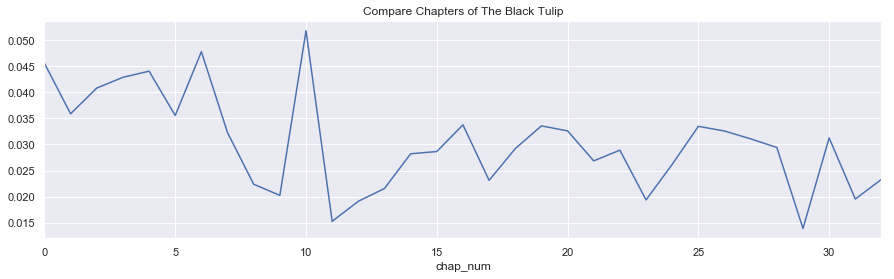

In [37]:
D.tf.plot(figsize=(15,4), title = 'Compare Chapters of The Black Tulip')

In [34]:
chap_ids = D.index.tolist()
pairs = [(i,j) for i in chap_ids for j in chap_ids if j > i]

In [35]:
BT_P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
BT_P.index.names = ['doc_x','doc_y']

In [36]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [38]:
BT_P['euclidean'] = 0
BT_P['euclidean'] = BT_P.apply(euclidean, 1)

In [39]:
BT_PME = BT_P.euclidean.unstack().fillna(0)

In [40]:
BT_PME.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.120193,0.125535,0.126845,0.124475,0.136814,0.122057,0.135295,0.138433,0.141738,0.114281,...,0.135004,0.133299,0.130249,0.124522,0.140401,0.133068,0.143813,0.138263,0.143651,0.127746
1,0.000000,0.119406,0.126147,0.127284,0.138863,0.120859,0.136137,0.139013,0.140628,0.112570,...,0.135542,0.133921,0.131431,0.123453,0.141325,0.134363,0.144552,0.142040,0.145333,0.130335
2,0.000000,0.000000,0.117717,0.130018,0.141002,0.124933,0.137659,0.139262,0.143140,0.117712,...,0.135199,0.133791,0.129309,0.125252,0.142677,0.133915,0.141931,0.142659,0.141096,0.131324
3,0.000000,0.000000,0.000000,0.129320,0.140980,0.125979,0.138293,0.136702,0.143825,0.118998,...,0.134681,0.133982,0.129679,0.124982,0.142774,0.131432,0.139862,0.143977,0.135818,0.131433
4,0.000000,0.000000,0.000000,0.000000,0.125039,0.113293,0.123571,0.135174,0.140599,0.109283,...,0.130702,0.125311,0.125082,0.117053,0.137862,0.131624,0.141101,0.135179,0.142685,0.121833


In [41]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    a = np.sqrt(D1.sum()**2)
    b = np.sqrt(D2.sum()**2)
    c = np.sqrt(a) * np.sqrt(b)
    z = y / c
    return z

In [42]:
BT_P['cosine'] = BT_P.apply(cosine, 1)
BT_PMC = BT_P.cosine.unstack().fillna(0)
BT_PMC.head()

doc_y,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
doc_x,,,,,,,,,,,,,,,,,,,,,
0,0.000952,0.000713,0.000690,0.000386,0.000249,0.000324,0.000350,0.000360,0.000334,0.000342,...,0.000206,0.000208,0.000262,0.000364,0.000252,0.000347,0.000345,0.000380,0.000382,0.000400
1,0.000000,0.001230,0.000878,0.000332,0.000214,0.000505,0.000404,0.000430,0.000532,0.000556,...,0.000269,0.000266,0.000287,0.000558,0.000288,0.000370,0.000403,0.000250,0.000370,0.000346
2,0.000000,0.000000,0.001461,0.000234,0.000141,0.000321,0.000366,0.000480,0.000414,0.000318,...,0.000369,0.000349,0.000512,0.000509,0.000260,0.000467,0.000681,0.000272,0.000768,0.000349
3,0.000000,0.000000,0.000000,0.000320,0.000185,0.000304,0.000373,0.000710,0.000415,0.000289,...,0.000462,0.000388,0.000543,0.000586,0.000302,0.000687,0.000903,0.000231,0.001228,0.000393
4,0.000000,0.000000,0.000000,0.000000,0.000687,0.000576,0.000845,0.000343,0.000177,0.000378,...,0.000249,0.000478,0.000350,0.000577,0.000192,0.000213,0.000296,0.000355,0.000212,0.000520


## Cosine Similarity

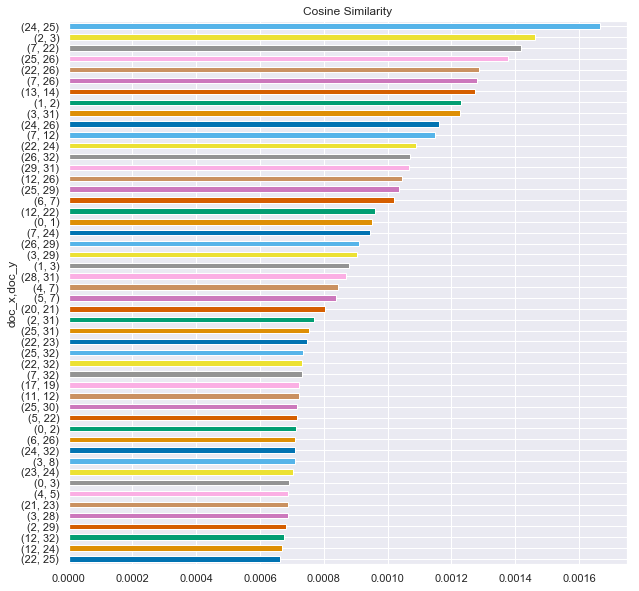

In [43]:
BT_P.cosine.sort_values(ascending=True).tail(50).plot(kind='barh', color=sns.color_palette('colorblind'), figsize=(10,10), title = 'Cosine Similarity')

## Compare Euclidean and Cosine Metrics

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


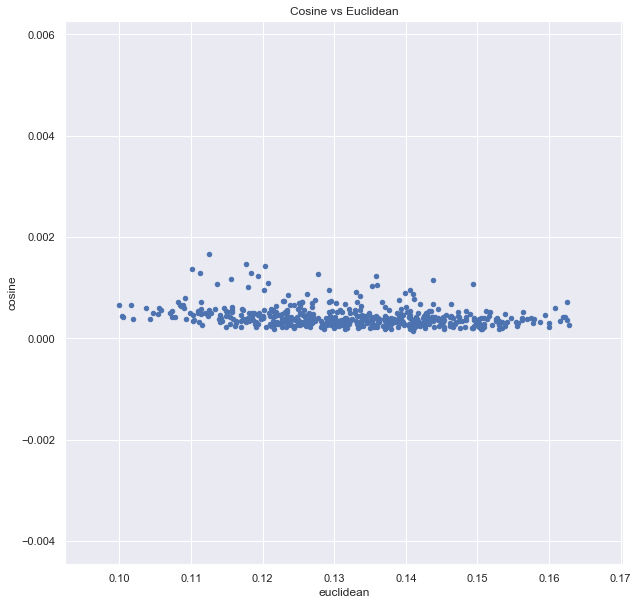

In [44]:
BT_P.plot(kind='scatter', x='euclidean', y='cosine', figsize=(10,10), title='Cosine vs Euclidean')

In [45]:
import matplotlib.pyplot as plt

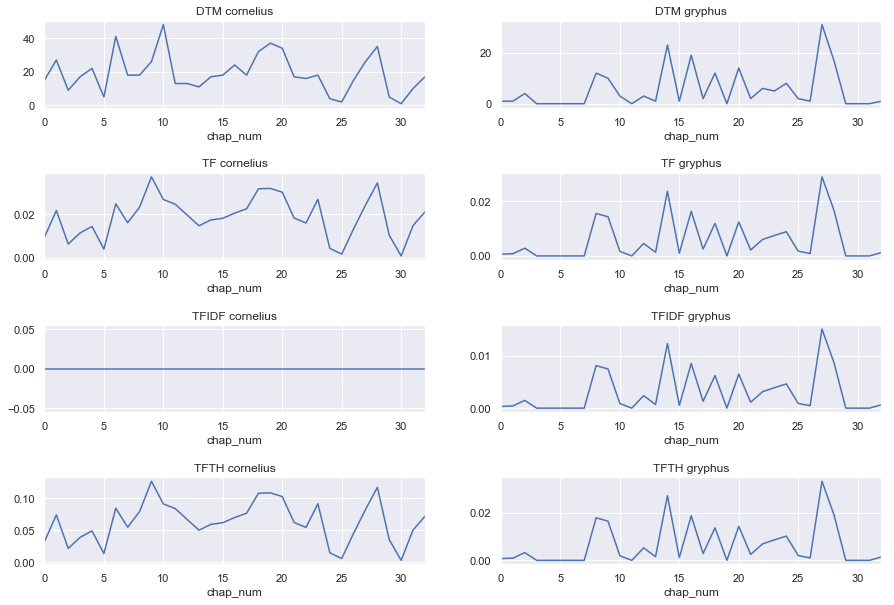

In [46]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('cornelius gryphus'.split()):
    W = get_term_id(BT_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

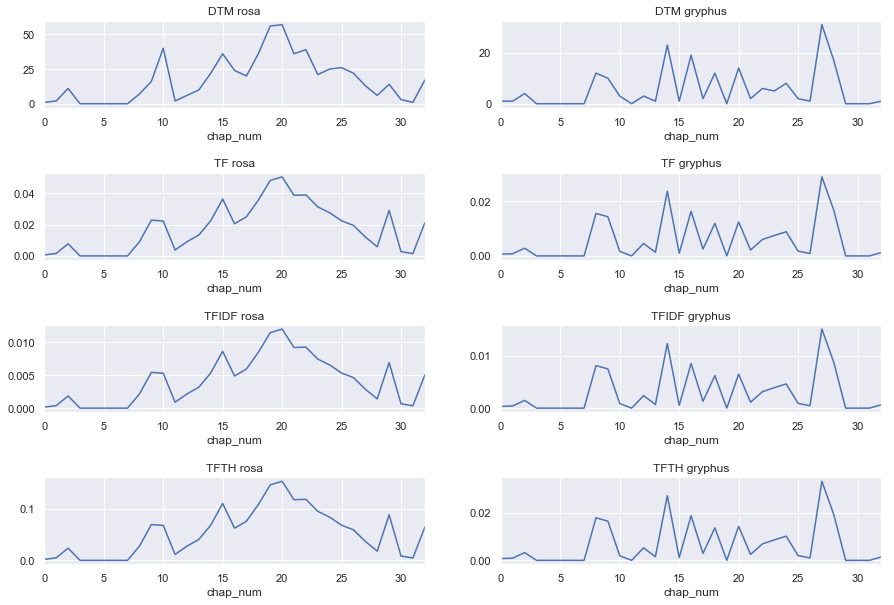

In [48]:
FIG = dict(figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2)
for i, w in enumerate('rosa gryphus'.split()):
    W = get_term_id(BT_V, w)
    DTM[W].plot(**FIG, ax=axes[0, i], title="DTM {}".format(w))
    TF[W].plot(**FIG, ax=axes[1, i], title="TF {}".format(w))
    TFIDF[W].plot(**FIG, ax=axes[2, i], title="TFIDF {}".format(w))
    TFTH[W].plot(**FIG, ax=axes[3, i], title="TFTH {}".format(w))
fig.subplots_adjust(hspace=.75)

In [49]:
BT_V.to_csv('The_Black_Tulip_V.csv', index=False)

## Visualize KDE Plots

In [50]:
BT_K.head()

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                      
0        0        0        0          NN   Chapter     0    0   chapter   
                  1        0          DT         A     0    0         a   
                           1          JJ  Grateful     0    0  grateful   
                           2          NN    People     0    0    people   
         1        0        0          IN        On     0    0        on   

                                      term_id  
chap_num para_num sent_num token_num           
0        0        0        0              893  
                  1        0                0  
                           1             2552  
                           2             4058  
         1        0        0             3874

In [51]:
lmk = BT_K.copy()

In [52]:
tt = lmk[['term_str','term_id']]
tt.head()

term_str  term_id
chap_num para_num sent_num token_num                   
0        0        0        0           chapter      893
                  1        0                 a        0
                           1          grateful     2552
                           2            people     4058
         1        0        0                on     3874

In [53]:
K = tt.reset_index()

In [54]:
K.rename_axis('offset', inplace=True)

In [55]:
K = K[['term_str','term_id']]
K.head(11).T

offset,0,1,2,3,4,5,6,7,8,9,10
term_str,chapter,a,grateful,people,on,the,of,august,the,city,of
term_id,893,0,2552,4058,3874,5619,3849,394,5619,958,3849


In [56]:
vocab_weight = 'tfidf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 5000
kde_samples = 1000

In [57]:
V1 = BT_V[(BT_V[vocab_weight] > BT_V[vocab_weight].quantile(vocab_weight_quantile)) & (BT_V.n >= vocab_min_n)]

In [58]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,664,4762,5546,3630,3862,2601,5096,4288,4120,825
term_str,boxtel,rosa,systens,monseigneur,officer,gryphus,sir,prince,pigeons,carriage
n,190,569,47,46,52,179,84,86,27,42
p,0.00256504,0.00768161,0.000634509,0.000621009,0.00070201,0.00241654,0.00113402,0.00116102,0.000364505,0.000567008
port_stem,boxtel,rosa,systen,monseigneur,offic,gryphu,sir,princ,pigeon,carriag
stop,0,0,0,0,0,0,0,0,0,0
df,13,28,7,7,9,23,16,18,5,9
tf_sum,0.182383,0.581089,0.0452527,0.0448853,0.0524844,0.183281,0.0847743,0.0971154,0.0310543,0.0434429
tf_mean,0.00552677,0.0176087,0.00137129,0.00136016,0.00159044,0.00555397,0.00256892,0.00294289,0.00094104,0.00131645
tf_max,0.0304931,0.0505765,0.0216075,0.0104165,0.0148147,0.0288639,0.0177776,0.0229164,0.0161072,0.0177776
tfidf_sum,0.245115,0.137741,0.101232,0.10041,0.0983803,0.0954586,0.0885378,0.0849244,0.0845443,0.0814324


In [59]:
TOP_TERMS = BT_V.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()

In [60]:
TOP_TERMS

['boxtel',
 'rosa',
 'systens',
 'monseigneur',
 'officer',
 'gryphus',
 'sir',
 'prince',
 'pigeons',
 'carriage',
 'john',
 'bulbs',
 'de',
 'tulip',
 'bulb',
 'jacob',
 'witt',
 'brother',
 'isaac',
 'president',
 'haarlem',
 'highness',
 'tulips',
 'william',
 'guilders',
 'prison',
 'stolen',
 'baerle',
 'oh',
 'key']

In [61]:
K = K[K.term_id.isin(V1.index)]

In [62]:
K.head(11).T

offset,3,9,12,13,26,47,61,64,69,80,111
term_str,people,city,hague,always,day,large,city,hague,seven,black,buytenhof
term_id,4058,958,2628,187,1389,3243,958,2628,4978,586,768


In [63]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [64]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [65]:
B.head()

,offset,x
term_str,,
ah,"[6667, 11655, 19785, 21059, 31743, 34863, 3530...","[[6667], [11655], [19785], [21059], [31743], [..."
air,"[7416, 14282, 14312, 14810, 19511, 20728, 2158...","[[7416], [14282], [14312], [14810], [19511], [..."
alone,"[5819, 6822, 7189, 11051, 13095, 18255, 24470,...","[[5819], [6822], [7189], [11051], [13095], [18..."
along,"[2341, 2863, 3850, 3852, 7010, 7468, 8476, 897...","[[2341], [2863], [3850], [3852], [7010], [7468..."
already,"[1117, 1653, 4136, 10761, 10936, 16827, 17285,...","[[1117], [1653], [4136], [10761], [10936], [16..."


In [66]:
from sklearn.neighbors import KernelDensity as KDE
scale_max = K.index.max()
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

In [67]:
B.head()

,offset,x,kde,scores
term_str,,,,
ah,"[6667, 11655, 19785, 21059, 31743, 34863, 3530...","[[6667], [11655], [19785], [21059], [31743], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-14.086923785915221, -14.065154944298023, -14..."
air,"[7416, 14282, 14312, 14810, 19511, 20728, 2158...","[[7416], [14282], [14312], [14810], [19511], [...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-13.736851046678133, -13.712343933749302, -13..."
alone,"[5819, 6822, 7189, 11051, 13095, 18255, 24470,...","[[5819], [6822], [7189], [11051], [13095], [18...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.51624919486271, -12.495670038546415, -12...."
along,"[2341, 2863, 3850, 3852, 7010, 7468, 8476, 897...","[[2341], [2863], [3850], [3852], [7010], [7468...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-10.84331668298066, -10.827957863305683, -10...."
already,"[1117, 1653, 4136, 10761, 10936, 16827, 17285,...","[[1117], [1653], [4136], [10761], [10936], [16...","KernelDensity(algorithm='auto', atol=0, bandwi...","[-12.08465185130078, -12.076569973892687, -12...."


In [68]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

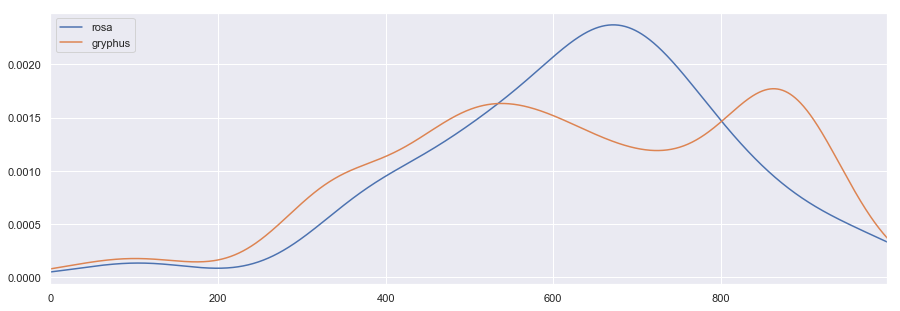

In [70]:
FIG = dict(figsize=(15, 5))
PLOTS.loc['rosa'].plot(**FIG)
PLOTS.loc['gryphus'].plot(**FIG)
plt.legend(loc='upper left') 

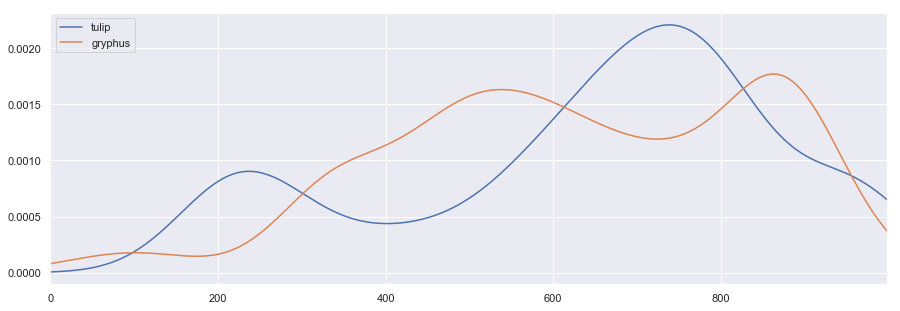

In [73]:
PLOTS.loc['tulip'].plot(**FIG)
PLOTS.loc['gryphus'].plot(**FIG)
plt.legend(loc='upper left') 

## Compute TFIDF

In [74]:
WORDS = (BT_K.punc == 0) & (BT_K.num == 0) & BT_K.term_id.isin(BT_V[BT_V.stop==0].index)

In [75]:
BOW = BT_K[WORDS].groupby(OHCO[:1]+['term_id'])['term_id'].count()

In [76]:
DTM = BOW.unstack().fillna(0)

In [77]:
alpha = .000001 
alpha_sum = alpha * BT_V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [78]:
N_docs = DTM.shape[0]
BT_V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / BT_V[BT_V.stop==0]['df'])

In [79]:
TFIDF.head()

term_id,1,2,3,4,5,6,7,8,9,10,...,6304,6305,6306,6307,6309,6310,6315,6316,6317,6318
chap_num,,,,,,,,,,,,,,,,,,,,,
0,2.196456e-09,2.567859e-09,3.202777e-09,2.567859e-09,0.000874,3.202777e-09,3.202777e-09,2.567859e-09,3.202781e-03,3.202777e-09,...,2.196458e-03,1.932943e-03,3.202777e-09,3.202777e-09,2.293534e-03,3.202777e-09,2.196456e-09,3.202777e-09,1.932941e-09,3.202777e-09
1,2.789850e-09,3.261592e-09,4.068039e-09,3.261592e-09,0.001110,4.068039e-09,4.068039e-09,3.261592e-09,4.068039e-09,4.068039e-09,...,2.789850e-09,2.455144e-09,4.068039e-09,4.068039e-09,5.826310e-10,4.068039e-09,2.789850e-09,4.068039e-09,2.455144e-09,4.068039e-09
2,2.451748e-09,2.866319e-09,3.575033e-09,2.866319e-09,0.000244,3.575033e-09,3.575033e-09,2.866319e-09,3.575033e-09,3.575033e-09,...,2.451748e-09,2.157605e-09,3.575033e-09,3.575033e-09,3.584154e-03,3.575033e-09,2.451748e-09,3.575033e-09,2.157607e-03,3.575033e-09
3,2.334290e-09,2.728999e-09,3.403761e-09,2.728999e-09,0.000464,3.403761e-09,3.403761e-09,2.728999e-09,3.403761e-09,3.403761e-09,...,2.334290e-09,2.054238e-09,3.403761e-09,3.403761e-09,5.362411e-03,3.403761e-09,2.334290e-09,3.403761e-09,2.054238e-09,3.403761e-09
4,2.271449e-09,2.655534e-09,3.312130e-09,2.655536e-03,0.000452,3.312130e-09,6.624263e-03,2.655536e-03,3.312130e-09,3.312130e-09,...,2.271449e-09,1.998939e-03,3.312130e-09,3.312133e-03,4.743684e-10,3.312130e-09,2.271449e-09,3.312130e-09,1.998937e-09,3.312130e-09


## Principal Component Analysis

In [80]:
def get_pca(df, k=2):
    from sklearn.decomposition import PCA
    pca = PCA(k)
    X = pd.DataFrame(pca.fit_transform(df))
    X.index = df.index.tolist()
    return X

In [81]:
pca1 = get_pca(TFIDF, k=2)
pca1

,0,1
0,-0.014303,0.004760
1,-0.022726,0.000573
2,-0.035093,-0.009526
3,-0.038951,-0.010012
4,0.016102,-0.005988
5,0.028081,-0.009888
6,0.010035,-0.003002
7,0.037921,-0.018819
8,-0.009981,0.010606
9,-0.015119,0.019071


In [82]:
X = np.array(pca1)
X

array([[-1.43028687e-02,  4.75973273e-03],
       [-2.27255391e-02,  5.72804546e-04],
       [-3.50934170e-02, -9.52611029e-03],
       [-3.89508977e-02, -1.00121577e-02],
       [ 1.61020602e-02, -5.98764336e-03],
       [ 2.80809190e-02, -9.88844556e-03],
       [ 1.00350570e-02, -3.00179233e-03],
       [ 3.79209785e-02, -1.88193933e-02],
       [-9.98124224e-03,  1.06056702e-02],
       [-1.51187084e-02,  1.90706870e-02],
       [ 1.81118875e-03,  2.65287201e-03],
       [ 2.38692645e-03,  8.32713324e-02],
       [ 5.90186766e-02, -8.85536076e-03],
       [ 1.46681463e-02,  4.31859166e-02],
       [ 4.54817952e-04,  1.93572057e-02],
       [ 4.18966865e-03,  5.33595402e-03],
       [-2.60672242e-05,  4.65318512e-03],
       [ 2.90602807e-03,  2.57204177e-03],
       [-3.71888741e-04,  6.13887387e-03],
       [ 1.12027945e-03,  3.39423954e-03],
       [-1.60557602e-03,  2.60431939e-03],
       [-8.84122835e-04,  1.55822342e-03],
       [ 2.92777051e-02, -1.41404347e-02],
       [-5.

In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [84]:
print(pca.components_)

[[1. 0.]
 [0. 1.]]


In [85]:
print(pca.explained_variance_)

[0.00050695 0.00046221]


In [86]:
print(pca.mean_)

[-1.05134756e-19  7.35943293e-19]


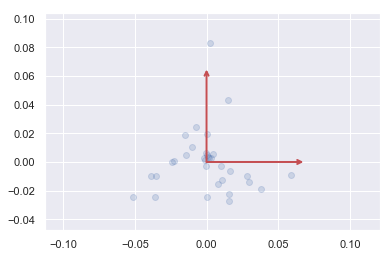

In [87]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='r')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## Sentiment Analysis

In [88]:
import sqlite3

In [89]:
# Developed in other notebook
lex_db = 'lexicon/lexicons.db'

In [90]:
text_db = 'db/The_Black_Tulip.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

emo = 'bing_sentiment'
#emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

In [91]:
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

In [92]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [93]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-1.0
abate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
abdicate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0


In [94]:
emo_cols = combo.columns

In [95]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'gi_sentiment'],
      dtype='object')

In [96]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [97]:
tokens = tokens.join(combo, on='term_str', how='left')

In [98]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
1         5         1         2           NaN
15        19        3         15          NaN
18        60        0         35          NaN
8         44        2         9           NaN
31        13        0         6           NaN
25        88        0         14          NaN
9         6         0         9           NaN
17        103       0         9           NaN
8         14        0         17          NaN
26        58        3         8           NaN
Name: bing_sentiment, dtype: float64

In [99]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [100]:
tokens.head(10)

pos token_str  punc  num  term_str  \
chap_num para_num sent_num token_num                                       
0        0        0        0           NN   Chapter     0    0   chapter   
                           1           CD         1     0    1      None   
                  1        0           DT         A     0    0         a   
                           1           JJ  Grateful     0    0  grateful   
                           2           NN    People     0    0    people   
         1        0        0           IN        On     0    0        on   
                           1           DT       the     0    0       the   
                           2           CD      20th     0    1      None   
                           3           IN        of     0    0        of   
                           4          NNP    August     0    0    august   

                                      term_id  nrc_anger  nrc_anticipation  \
chap_num para_num sent_num token_num                                         
0        0        0        0              893        0.0               0.0   
                           1               -1        0.0               0.0   
                  1        0                0        0.0               0.0   
                           1             2552        0.0               0.0   
                           2             4058        0.0               0.0   
         1        0        0             3874        0.0               0.0   
                           1             5619        0.0               0.0   
                           2               -1        0.0               0.0   
                           3             3849        0.0               0.0   
                           4              394        0.0               0.0   

                                      nrc_disgust  nrc_fear  nrc_joy  \
chap_num para_num sent_num token_num                                   
0        0        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                  1        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   
         1        0        0                  0.0       0.0      0.0   
                           1                  0.0       0.0      0.0   
                           2                  0.0       0.0      0.0   
                           3                  0.0       0.0      0.0   
                           4                  0.0       0.0      0.0   

                                      nrc_negative  nrc_positive  nrc_sadness  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                  1        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   
         1        0        0                   0.0           0.0          0.0   
                           1                   0.0           0.0          0.0   
                           2                   0.0           0.0          0.0   
                           3                   0.0           0.0          0.0   
                           4                   0.0           0.0          0.0   

                                      nrc_surprise  nrc_trust  bing_negative  \
chap_num para_num sent_num token_num                                           
0        0        0        0                   0.0        0.0            0.0   
                           1                   0.0        0.0            0.0   
                  1        0  

In [101]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

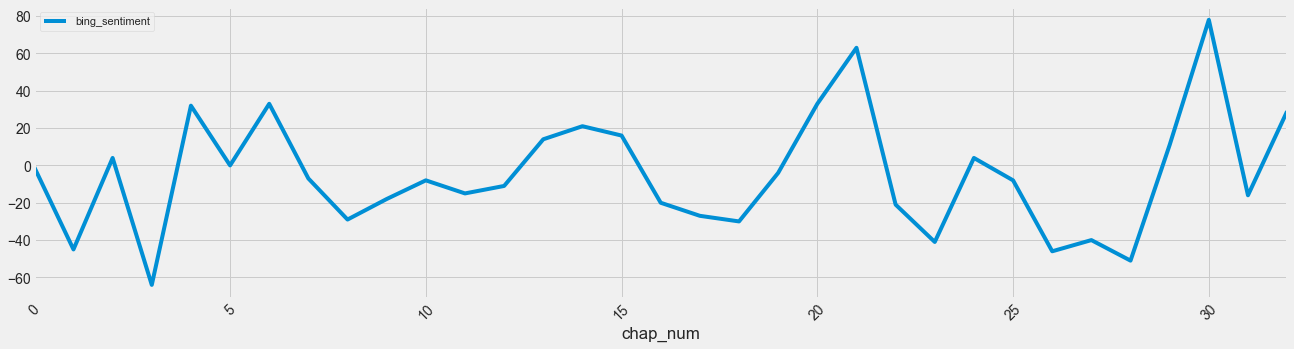

In [102]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

In [103]:
by_chaps= tokens.groupby(CHAPS)[emo_cols].sum()

In [104]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [105]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0             <span class='sent0'>Chapter</span>
                              1                   <span class='sent0'>1</span>
                    1         0                   <span class='sent0'>A</span>
                              1            <span class='sent1'>Grateful</span>
                              2              <span class='sent0'>People</span>
Name: html, dtype: object

In [106]:
by_chaps['chaps_str'] = tokens.groupby(CHAPS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_chaps['html_str'] = tokens.groupby(CHAPS).html.apply(lambda x: x.str.cat(sep=' '))

In [107]:
by_chaps[['chaps_str', 'html_str']].head()

,chaps_str,html_str
chap_num,,
0,chapter a grateful people on the of august the...,<span class='sent0'>Chapter</span> <span class...
1,chapter the two brothers as the fair rosa with...,<span class='sent0'>Chapter</span> <span class...
2,chapter the pupil of john de witt whilst the c...,<span class='sent0'>Chapter</span> <span class...
3,chapter the murderers the young man with his h...,<span class='sent0'>Chapter</span> <span class...
4,chapter the tulip fancier and his neighbour wh...,<span class='sent0'>Chapter</span> <span class...


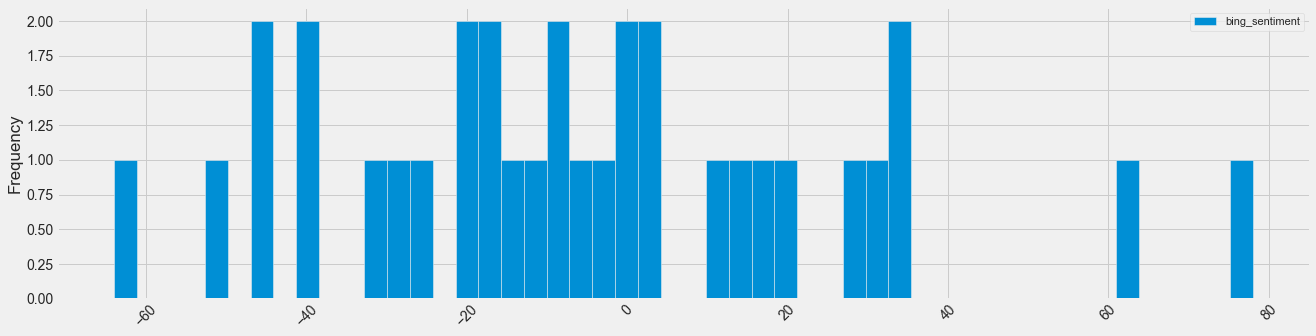

In [108]:
by_chaps[emo].plot.hist(**FIG, bins=50)

### Positive

In [109]:
by_chaps.sort_values(emo, ascending=False)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
30,78.0,chapter haarlem haarlem whither three days ago...
21,63.0,chapter the opening of the flower the night pa...
6,33.0,chapter the happy man makes acquaintance with ...
20,33.0,chapter the second bulb the night was a happy ...
4,32.0,chapter the tulip fancier and his neighbour wh...
32,29.0,chapter conclusion van baerle led by four guar...
14,21.0,chapter the little grated window gryphus was f...
15,16.0,chapter master and pupil the worthy master gry...
13,14.0,chapter the pigeons of dort it was indeed in i...


### Negative

In [110]:
by_chaps.sort_values(emo, ascending=True)[[emo,'chaps_str']].head(20)

,bing_sentiment,chaps_str
chap_num,,
3,-64.0,chapter the murderers the young man with his h...
28,-51.0,chapter in which van baerle before leaving loe...
26,-46.0,chapter the third bulb boxtel s return was sca...
1,-45.0,chapter the two brothers as the fair rosa with...
23,-41.0,chapter the black tulip changes masters cornel...
27,-40.0,chapter the hymn of the flowers whilst the eve...
18,-30.0,chapter the maid and the flower but poor rosa ...
8,-29.0,chapter the family cell it was about midnight ...
17,-27.0,chapter rosa s lover rosa had scarcely pronoun...


### Multinomial Emotions

In [111]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [112]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


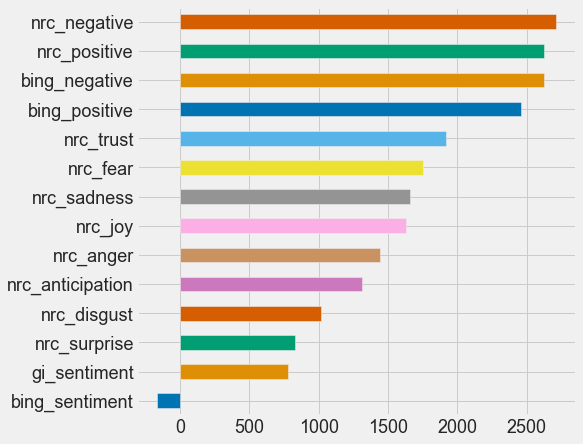

In [113]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18, color=sns.color_palette('colorblind'))

### Visualize KDE for Emotions

In [114]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [115]:
B.head()

,x
emo,
nrc_anger,"[[116], [117], [119], [132], [152], [275], [32..."
nrc_anticipation,"[[88], [358], [411], [439], [567], [579], [637..."
nrc_disgust,"[[116], [132], [152], [312], [327], [346], [41..."
nrc_fear,"[[35], [76], [116], [117], [132], [152], [275]..."
nrc_joy,"[[209], [220], [221], [328], [409], [411], [43..."


In [116]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

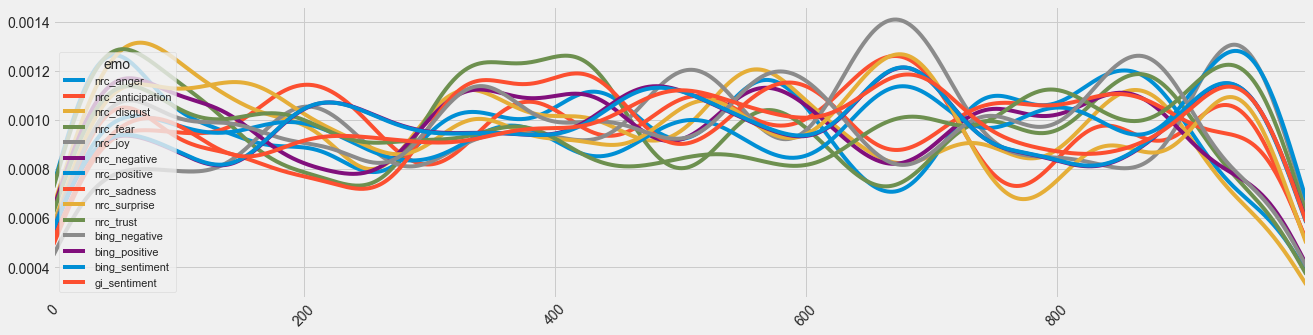

In [117]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T
PLOTS.plot(**FIG)

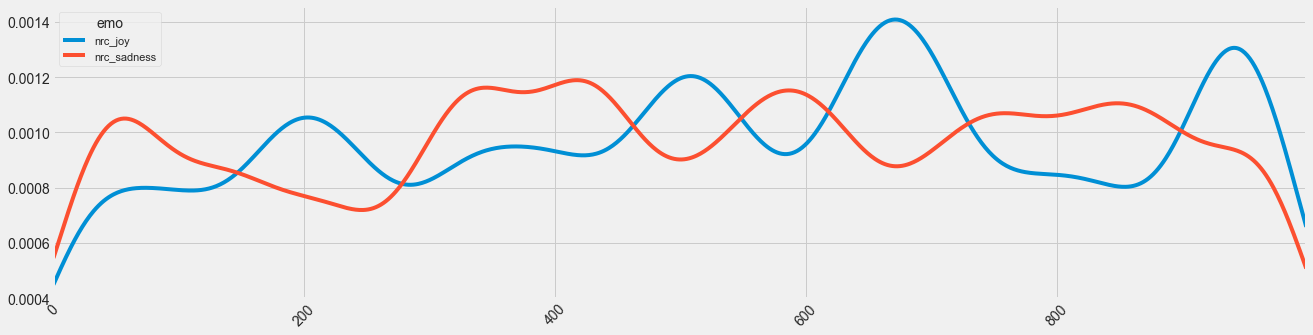

In [118]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

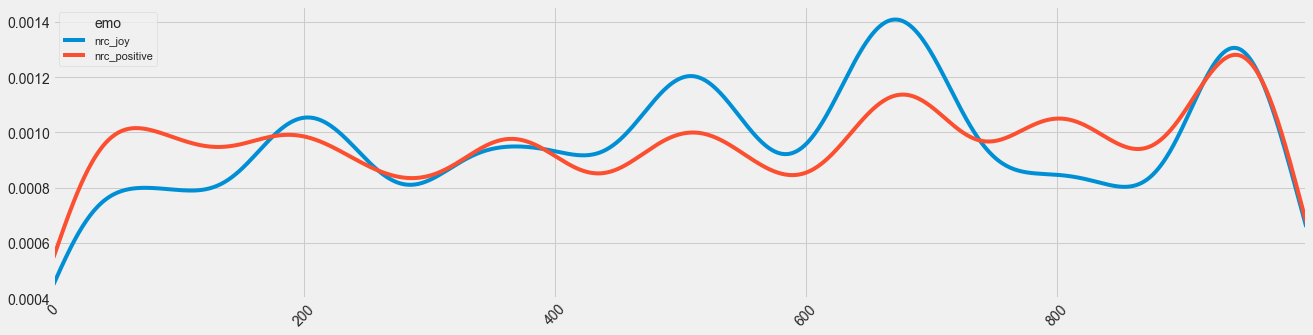

In [119]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

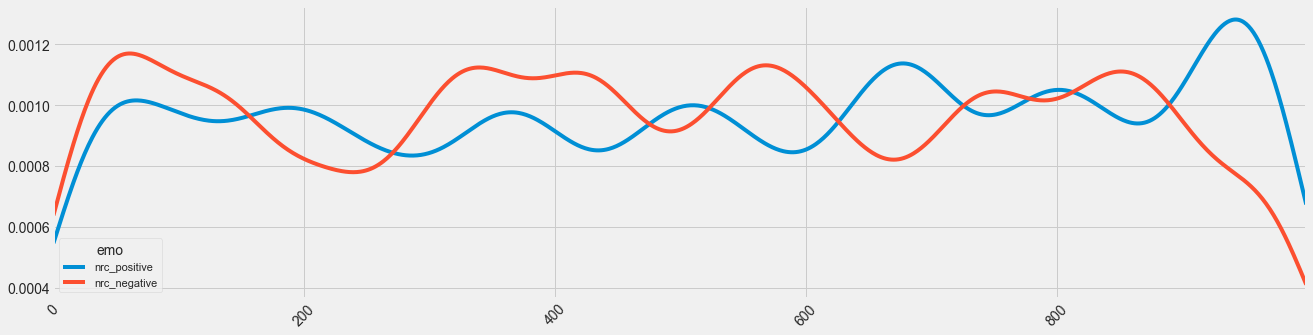

In [120]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

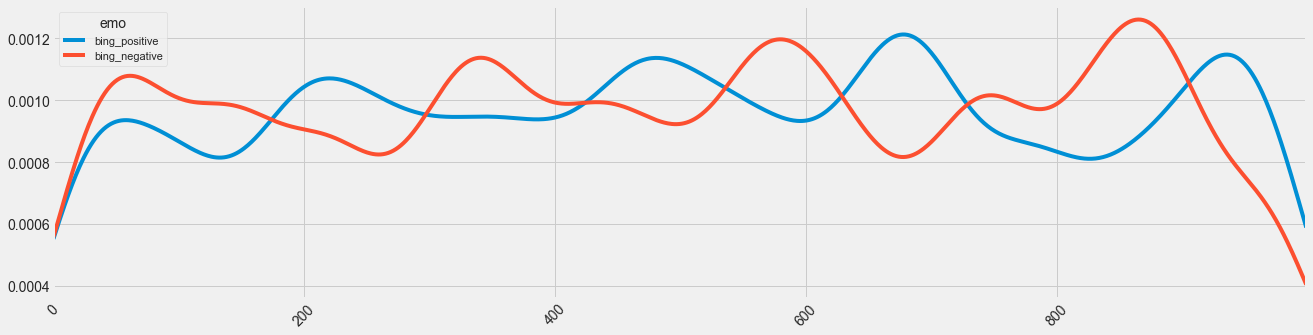

In [121]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)